[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](['a href=', 'https://colab.research.google.com/github/cbc-univie/mdy-newanalysis-package/blob/master/docs/notebooks/dielectrics.ipynb', ' target=', '_parent', ''])

# Dielectrics

We calculate MDMD.

In [23]:
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
try:
    import MDAnalysis
except ModuleNotFoundError:
    !conda install --yes --prefix {sys.prefix} MDAnalysis
    import MDAnalysis

The following functions are imported from out newanalysis extension:

In [24]:
try:
    from newanalysis.correl import correlateParallel
    from newanalysis.helpers import dipByResidue
    from newanalysis.functions import atomsPerResidue, residueFirstAtom
except ModuleNotFoundError as e:
    print("Install newanalysis fist.")
    print("Go to the newanalysis_source folder and run:")
    print("conda activate newanalysis-dev")
    print("pip install .")
    raise(e)

## Preprocessing

Next we create our MDAnalysis Universe:

In [25]:
base='../../test_cases/data/emim_dca_equilibrium/'
psf=base+'emim_dca.psf'
#Check PSF:
if np.array_equal(MDAnalysis.Universe(psf).atoms.masses, MDAnalysis.Universe(psf).atoms.masses.astype(bool)):
    print("Used wrong PSF format (masses unreadable!)")
    sys.exit()

u=MDAnalysis.Universe(psf,base+"emim_dca.dcd")

skip=20
dt=round(u.trajectory.dt,4)

n = int(u.trajectory.n_frames/skip)
if u.trajectory.n_frames%skip != 0:
    n+=1

Now we do the selections

In [26]:
sel_cat1  = u.select_atoms("resname EMIM")
ncat1     = sel_cat1.n_residues
mass_cat1 = sel_cat1.masses
charge_cat1 = sel_cat1.charges
com_cat1  = np.zeros((n,ncat1,3),dtype=np.float64)
mdcat1    = np.zeros((n,3),dtype=np.float64)
apr_cat1 = atomsPerResidue(sel_cat1)
rfa_cat1 = residueFirstAtom(sel_cat1)


print("Number EMIM   = ",ncat1)

sel_an1  = u.select_atoms("resname DCA")
nan1     = sel_an1.n_residues
mass_an1 = sel_an1.masses
charge_an1 = sel_an1.charges
com_an1  = np.zeros((n,nan1, 3),dtype=np.float64)
mdan1    = np.zeros((n,3),dtype=np.float64)
apr_an1 = atomsPerResidue(sel_an1)
rfa_an1 = residueFirstAtom(sel_an1)

print("Number DCA    = ",nan1)

Number EMIM   =  1000
Number DCA    =  1000


## Analysis

In [27]:
md = np.zeros((n,3),dtype=np.float64)

ctr=0
start=time.time()
print("")

for ts in u.trajectory[::skip]:
    print("\033[1AFrame %d of %d" % (ts.frame,u.trajectory.n_frames), "\tElapsed time: %.2f hours" % ((time.time()-start)/3600))
    
    # efficiently calculate center-of-mass coordinates
    coor_cat1 = np.ascontiguousarray(sel_cat1.positions,dtype='double')
    coor_an1 = np.ascontiguousarray(sel_an1.positions,dtype='double')
    com_an1  = sel_an1.center_of_mass(compound='residues')
    com_cat1 = sel_cat1.center_of_mass(compound='residues')
    mdcat1[ctr] += np.sum(dipByResidue(coor_cat1,charge_cat1,mass_cat1,ncat1,apr_cat1,rfa_cat1,com_cat1),axis=0)
    mdan1[ctr] += np.sum(dipByResidue(coor_an1,charge_an1,mass_an1,nan1,apr_an1,rfa_an1,com_an1),axis=0)

    #Alternatively, use
    #com_an1  = centerOfMassByResidue(sel_an1,coor=coor_an1,masses=mass_an1,apr=apr_an1,rfa=rfa_an1)
    #com_cat1 = centerOfMassByResidue(sel_cat1,coor=coor_cat1,masses=mass_cat1,apr=apr_cat1,rfa=rfa_cat1)
    #mdcat1[ctr] += np.sum(dipoleMomentByResidue(sel_cat1,coor=coor_cat1,charges=charge_cat1,masses=mass_cat1,com=com_cat1,apr=apr_cat1,rfa=rfa_cat1),axis=0)
    #mdan1[ctr]  += np.sum(dipoleMomentByResidue(sel_an1,coor=coor_an1,charges=charge_an1,masses=mass_an1,com=com_an1,apr=apr_an1,rfa=rfa_an1),axis=0)

    md[ctr]     += mdcat1[ctr]+mdan1[ctr]
    ctr+=1


Frame 0 of 100 	Elapsed time: 0.00 hours
Frame 20 of 100 	Elapsed time: 0.00 hours
Frame 40 of 100 	Elapsed time: 0.00 hours
Frame 60 of 100 	Elapsed time: 0.00 hours
Frame 80 of 100 	Elapsed time: 0.00 hours


Calculate <MD(0)MD(t)>

In [28]:
print("calculating <MD(0)MD(t)>")

# total
md = np.ascontiguousarray(md.T)
md0mdt = np.zeros(n)
correlateParallel(md,md,md0mdt,ltc=1)

#f1 = open("md0mdt.dat",'w')
#for i in range(len(md0mdt)):
#    f1.write("%5.5f\t%5.5f\n" % (i*skip*dt, md0mdt[i]))
#f1.close()

# cations
mdcat1 = np.ascontiguousarray(mdcat1.T)
md0mdt_cat = np.zeros(n)
correlateParallel(mdcat1,md,md0mdt_cat,ltc=1)
#f1 = open("md0mdt_emim.dat",'w')
#for i in range(len(md0mdt)):
#    f1.write("%5.5f\t%5.5f\n" % (i*skip*dt, md0mdt[i]))
#f1.close()


# anions
mdan1 = np.ascontiguousarray(mdan1.T)
md0mdt_an = np.zeros(n)
correlateParallel(mdan1,md,md0mdt_an,ltc=1)
#f1 = open("md0mdt_dca.dat",'w')
#for i in range(len(md0mdt)):
#    f1.write("%5.5f\t%5.5f\n" % (i*skip*dt, md0mdt[i]))
#f1.close()

calculating <MD(0)MD(t)>


## Plot the results

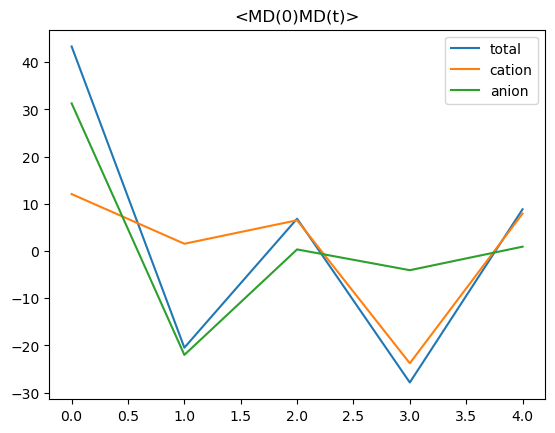

In [29]:
time = np.arange(ctr*dt)

plt.title("<MD(0)MD(t)>")
plt.plot(time,md0mdt, label="total")
plt.plot(time,md0mdt_cat, label="cation")
plt.plot(time,md0mdt_an, label="anion")
plt.legend();